# Анализ поведения пользователей мобильного приложения
Анализ поведения пользователей мобильного приложения "Ненужные вещи" с целью увеличения их вовлеченности.

## Цели исследования 
1. Проанализировать связь целевого события - просмотра контактов - и других действий пользователей.
2. Оценить, какие действия чаще всего совершают те пользователи, которые просматривают контакты.

## Загрузка и подготовка данных

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import datetime as dt
from datetime import datetime, timedelta
import seaborn as sns
from scipy.stats import binom
import plotly.express as px
from plotly import graph_objects as go
from IPython.display import display_html
pd.set_option('display.max_columns', 30)
pd.set_option("display.float_format", "{:.2f}".format)
pd.set_option('display.max_colwidth', 300)
import warnings
warnings.simplefilter('ignore')
plt.rcParams.update({'figure.figsize': (15,8)})
sns.set()
import requests
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

In [2]:
#сформируем датасет
data_link = 'https://code.s3.yandex.net/datasets/mobile_sources.csv'
data_sources = pd.read_csv(data_link)
display (data_sources.head())
display (data_sources.tail())
display (data_sources.sample(10))
display (data_sources.describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95, 0.99]).T)
display (data_sources.info())

userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google

userId  source
4288  b86fe56e-f2de-4f8a-b192-cd89a37ecd41  yandex
4289  424c0ae1-3ea3-4f1e-a814-6bac73e48ab1  yandex
4290  437a4cd4-9ba9-457f-8614-d142bc48fbeb  yandex
4291  c10055f0-0b47-477a-869e-d391b31fdf8f  yandex
4292  d157bffc-264d-4464-8220-1cc0c42f43a9  google

userId  source
1530  18c6d2da-dfec-45e8-9b96-ec0093335e4c  yandex
582   04053efe-fc60-4ad0-9ef0-c648e93d766b   other
819   8196713b-e0a6-44b7-b2af-2a8a7c2c716f   other
76    3f75d72c-a8c1-4db5-bddd-52eee2b1f838  google
3860  8ae13794-3867-4398-962a-89ef979d4807  google
293   a34fba38-0f99-4dbb-a04f-0f8c2327b9e5  google
532   dfdc0ac2-b63e-47f4-a06a-5fec9057e3c3   other
1043  53f821ae-d4a7-4621-bbc4-d7a97cad0985  yandex
2985  501df2de-15fe-4d0b-814f-3ed77e479cc7   other
642   5622bed3-de57-4e44-851a-89cb6a2e7596  yandex

count unique                                   top  freq
userId  4293   4293  020292ab-89bc-4156-9acf-68bc2783f894     1
source  4293      3                                yandex  1934

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


None

In [3]:
data_link = 'https://code.s3.yandex.net/datasets/mobile_dataset.csv'
data_dataset = pd.read_csv(data_link)
display (data_dataset.head())
display (data_dataset.tail())
display (data_dataset.sample(10))
display (data_dataset.describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95, 0.99]).T)
display (data_dataset.info())

event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   
2  2019-10-07 00:00:02.245341    tips_show   
3  2019-10-07 00:00:07.039334    tips_show   
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c

event.time event.name  \
74192  2019-11-03 23:53:29.534986  tips_show   
74193  2019-11-03 23:54:00.407086  tips_show   
74194  2019-11-03 23:56:57.041825   search_1   
74195  2019-11-03 23:57:06.232189  tips_show   
74196  2019-11-03 23:58:12.532487  tips_show   

                                    user.id  
74192  28fccdf4-7b9e-42f5-bc73-439a265f20e9  
74193  28fccdf4-7b9e-42f5-bc73-439a265f20e9  
74194  20850c8f-4135-4059-b13b-198d3ac59902  
74195  28fccdf4-7b9e-42f5-bc73-439a265f20e9  
74196  28fccdf4-7b9e-42f5-bc73-439a265f20e9

event.time   event.name  \
63908  2019-10-30 22:31:07.518083  photos_show   
54679  2019-10-27 23:06:06.414612    tips_show   
35002  2019-10-21 12:58:23.312325    tips_show   
2052   2019-10-07 21:41:23.202906  advert_open   
65943  2019-10-31 17:50:38.684631  advert_open   
722    2019-10-07 13:19:37.387196  photos_show   
10615  2019-10-11 16:58:42.265721    tips_show   
46123  2019-10-24 23:08:47.144923    tips_show   
10924  2019-10-11 19:29:14.311933  photos_show   
19087  2019-10-15 08:36:42.852970    tips_show   

                                    user.id  
63908  73391630-a930-4b16-a450-ec39f84936f1  
54679  b027f2d7-d9cb-4782-b410-4d100f5ef2f9  
35002  881152bf-c49d-4eed-923e-3c424b1a327f  
2052   f15c6c88-5083-4331-b213-c8dc9076d517  
65943  4060ea41-7ee3-4eb3-9c69-8cb63cd09747  
722    1daa906e-cf82-4e9c-a408-ce1730d4b64e  
10615  ad6f54bf-5c44-4fbb-ab6e-2fb28030f8f4  
46123  e387d029-59eb-41b9-9be5-5548389c079c  
10924  9c78948d-5850-4916-9d7f-341fec1b7737  
19087  78daca01-4dae-4076-b2b5-6e92ad6603be

count unique                                   top   freq
event.time  74197  74197            2019-10-07 00:00:00.431357      1
event.name  74197     16                             tips_show  40055
user.id     74197   4293  cb36854f-570a-41f4-baa8-36680b396370    478

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


None

### Описание данных

Датасет содержит данные о событиях, совершенных в мобильном приложении "Ненужные вещи". В нем пользователи продают свои ненужные вещи, размещая их на доске объявлений.

В датасете содержатся данные пользователей, впервые совершивших действия в приложении после 7 октября 2019 года.

Колонки в *mobile_sources.csv*: 

- `userId` — идентификатор пользователя,
- `source` — источник, с которого пользователь установил приложение.

Колонки в mobile_dataset.csv: **

- `event.time` — время совершения,
- `user.id` — идентификатор пользователя,
- `event.name` — действие пользователя.

Виды действий:

- `advert_open` — открыл карточки объявления,
- `photos_show` — просмотрел фотографий в объявлении,
- `tips_show` — увидел рекомендованные объявления,
- `tips_click` — кликнул по рекомендованному объявлению,
- `contacts_show` и `show_contacts` — посмотрел номер телефона,
- `contacts_call` — позвонил по номеру из объявления,
- `map` — открыл карту объявлений,
- `search_1`—`search_7` — разные действия, связанные с поиском по сайту,
- `favorites_add` — добавил объявление в избранное.

### Предобработка данных

#### Проверка данных на соответствие стилю и содержанию

In [4]:
data_sources.columns

Index(['userId', 'source'], dtype='object')

In [5]:
data_sources = data_sources.rename(
    columns = {'userId': 'user_id', 'source': 'source'})

In [6]:
data_dataset.columns

Index(['event.time', 'event.name', 'user.id'], dtype='object')

In [7]:
data_dataset = data_dataset.rename(
    columns = {'event.time': 'event_time', 'event.name': 'event_name', 'user.id': 'user_id'})

In [8]:
#обьединим датасеты для удобства
df = data_sources.merge(data_dataset, on='user_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     74197 non-null  object
 1   source      74197 non-null  object
 2   event_time  74197 non-null  object
 3   event_name  74197 non-null  object
dtypes: object(4)
memory usage: 2.8+ MB


In [9]:
data = df

#### Проверка пропусков и явных дубликатов

In [10]:
#изучим содержание датасета на предмет явных проблем
print('Количество явных дубликатов:', df.duplicated().sum())
print('=' * 45)
n=0
for column in df:
    print(f'Количество пропусков в столбце {df.columns[n]}:', df[column].isna().sum())
    print('=' * 45)
    print()        
    n += 1

Количество явных дубликатов: 0
Количество пропусков в столбце user_id: 0

Количество пропусков в столбце source: 0

Количество пропусков в столбце event_time: 0

Количество пропусков в столбце event_name: 0



#### Приведение данных к необходимым типам

In [11]:
#поменяем тип данных дат и добавим дополнительные
df['event_time'] = pd.to_datetime(df['event_time'])
df['event_date'] = df.event_time.dt.date
df

user_id  source  \
0      020292ab-89bc-4156-9acf-68bc2783f894   other   
1      020292ab-89bc-4156-9acf-68bc2783f894   other   
2      020292ab-89bc-4156-9acf-68bc2783f894   other   
3      020292ab-89bc-4156-9acf-68bc2783f894   other   
4      020292ab-89bc-4156-9acf-68bc2783f894   other   
...                                     ...     ...   
74192  d157bffc-264d-4464-8220-1cc0c42f43a9  google   
74193  d157bffc-264d-4464-8220-1cc0c42f43a9  google   
74194  d157bffc-264d-4464-8220-1cc0c42f43a9  google   
74195  d157bffc-264d-4464-8220-1cc0c42f43a9  google   
74196  d157bffc-264d-4464-8220-1cc0c42f43a9  google   

                      event_time   event_name  event_date  
0     2019-10-07 00:00:00.431357  advert_open  2019-10-07  
1     2019-10-07 00:00:01.236320    tips_show  2019-10-07  
2     2019-10-07 00:00:07.039334    tips_show  2019-10-07  
3     2019-10-07 00:01:27.770232  advert_open  2019-10-07  
4     2019-10-07 00:01:34.804591    tips_show  2019-10-07  
...                          ...          ...         ...  
74192 2019-11-03 23:46:47.068179          map  2019-11-03  
74193 2019-11-03 23:46:58.914787  advert_open  2019-11-03  
74194 2019-11-03 23:47:01.232230    tips_show  2019-11-03  
74195 2019-11-03 23:47:47.475102  advert_open  2019-11-03  
74196 2019-11-03 23:47:50.087645    tips_show  2019-11-03  

[74197 rows x 5 columns]

Данные приведены к стилю, датасеты обьеденены. Изменен тип данных у даты.

## Исследовательский анализ данных
Перед дальнейшей работой проведем глубокое исследование данных

In [12]:
#сколько всего событий в логе
print(f'Всего в логе {len(df)} событий.')
print(f'Всего пользователей в логе {len(df.user_id.unique())}.')
log = df['event_name'].value_counts().to_dict()
log

Всего в логе 74197 событий.
Всего пользователей в логе 4293.


{'tips_show': 40055,
 'photos_show': 10012,
 'advert_open': 6164,
 'contacts_show': 4450,
 'map': 3881,
 'search_1': 3506,
 'favorites_add': 1417,
 'search_5': 1049,
 'tips_click': 814,
 'search_4': 701,
 'contacts_call': 541,
 'search_3': 522,
 'search_6': 460,
 'search_2': 324,
 'search_7': 222,
 'show_contacts': 79}

In [13]:
#посмотрим количество событий
log = df.pivot_table(index=['event_name'], values='user_id', aggfunc=['count'])
log.columns = ['count']
log = log.sort_values(by = 'count', ascending = False).reset_index()

fig = px.bar(log.sort_values(by='count', ascending=True), # загружаем данные и заново их сортируем
             x='count', # указываем столбец с данными для оси X
             y='event_name', # указываем столбец с данными для оси Y
             text='count' # добавляем аргумент, который отобразит текст с информацией
                                # о количестве объявлений внутри столбца графика
            )
# оформляем график
fig.update_layout(title='Количество событий в данных',
                   xaxis_title='Количество событий',
                   yaxis_title='Виды событий')
fig.show() # выводим график

In [14]:
#визуализируем среднее количество событий каждой группы на пользователя
log['on_id']=log['count']/df['user_id'].nunique()
log['on_id'] = round(log['on_id'], 2)
fig = px.bar(log.sort_values(by='count', ascending=True), # загружаем данные и заново их сортируем
             x='on_id', # указываем столбец с данными для оси X
             y='event_name', # указываем столбец с данными для оси Y
             text='on_id' # добавляем аргумент, который отобразит текст с информацией
                                # о количестве объявлений внутри столбца графика
            )
# оформляем график
fig.update_layout(title='Количество событий в данных',
                   xaxis_title='Количество событий',
                   yaxis_title='Виды событий')
fig.show() # выводим график

Всего в логе 74197 событий и 4293 пользователей. Наиболее частым событием является tips_show, photos_show, advert_open

In [15]:
df.groupby('user_id')[['event_name']].count().describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95, 0.99])

event_name
count     4293.00
mean        17.28
std         29.13
min          1.00
5%           3.00
25%          5.00
50%          9.00
75%         17.00
95%         59.00
99%        132.00
max        478.00

В среднем, на каждого пользователя приходится 17 событий. Медианное количество при этом составляет 9, и всего у одного процента пользователей количество событий переваливает за 132. Большое различие между средним и медианным показывает наличие выбросов.

### Распределение пользователей и событий по источникам

In [16]:
source = df.groupby(['event_name', 'source'], as_index=False)[['user_id']].\
    count().sort_values(by = 'user_id', ascending = False).reset_index(drop=True)

fig = px.bar(source, # загружаем данные и заново их сортируем
             x='source', # указываем столбец с данными для оси X
             y='user_id', # указываем столбец с данными для оси Y
             color='event_name', # обозначаем категорию для разделения цветом
             text='event_name' # добавляем аргумент, который отобразит текст с информацией
                                # о количестве объявлений внутри столбца графика
            )
# оформляем график
fig.update_layout(title='Распределение событий по источникам',
                   xaxis_title='Время',
                   yaxis_title='Количество событий')
fig.update_xaxes(categoryorder='total descending')
fig.show()

Наиболее популярные источники yandex и google.

###  Распределение событий по времени

In [17]:
print(f'Максимальная дата события {df.event_time.max()}.')
print(f'Минимальная дата события {df.event_time.min()}.')
print(f'Сырые данные предоставлены за период {df.event_time.max() - df.event_time.min()}.')

Максимальная дата события 2019-11-03 23:58:12.532487.
Минимальная дата события 2019-10-07 00:00:00.431357.
Сырые данные предоставлены за период 27 days 23:58:12.101130.


In [18]:
#посмотрим распределение событий по времени
log_date = df.groupby(['event_date'], as_index=False)[['event_name']].\
    count().sort_values(by = 'event_name', ascending = False).reset_index(drop=True)

fig = px.bar(log_date, # загружаем данные и заново их сортируем
             x='event_date', # указываем столбец с данными для оси X
             y='event_name', # указываем столбец с данными для оси Y
             text='event_name' # добавляем аргумент, который отобразит текст с информацией
                                # о количестве объявлений внутри столбца графика
            )
# оформляем график
fig.update_layout(title='Распределение событий по времени',
                   xaxis_title='Время',
                   yaxis_title='Количество событий')
fig.update_xaxes(categoryorder='total descending')
fig.show()

In [19]:
df['event_day']=df['event_time'].dt.isocalendar().day
day = df.groupby(['event_name', 'event_day'], as_index=False)[['user_id']].\
    count().sort_values(by = 'user_id', ascending = False).reset_index(drop=True)
#px.bar(day,title='Количество событий по дням недели',color='event_name',labels={"value":"count"})
fig = px.bar(day, # загружаем данные и заново их сортируем
             x='event_day', # указываем столбец с данными для оси X
             y='user_id', # указываем столбец с данными для оси Y
             color='event_name', # обозначаем категорию для разделения цветом
             text='event_name' # добавляем аргумент, который отобразит текст с информацией
                                # о количестве объявлений внутри столбца графика
            )
# оформляем график
fig.update_layout(title='Количество событий по дням недели',
                   xaxis_title='Время',
                   yaxis_title='Количество событий')
fig.update_xaxes(categoryorder='total descending')
fig.show()

Максимальная дата события 2019-11-03 23:58:12, минимальная дата события 2019-10-07 00:00:00, сырые данные предоставлены за период 27 days 23:58:12. За весь период данных не видно резких скачков и падений количества событий. Имеет смысл в исследовании рассматривать весь предоставленный период. В понедельник наидольшая активность, затем она постепенно падает к субботе и возрастает снова в воскресенье.

### Анализ различных событий поиска `search_1`— `search_7`

In [20]:
list_search = ['search_1', 'search_2', 'search_3', 'search_4', 'search_5', 'search_6', 'search_7']
log_search = df.query('event_name in @list_search')

In [21]:
#посмотрим количество событий
log = log_search.pivot_table(index=['event_name'], values='user_id', aggfunc=['count'])
log.columns = ['count']
log = log.sort_values(by = 'count', ascending = False).reset_index()

fig = px.bar(log.sort_values(by='count', ascending=True), # загружаем данные и заново их сортируем
             x='count', # указываем столбец с данными для оси X
             y='event_name', # указываем столбец с данными для оси Y
             text='count' # добавляем аргумент, который отобразит текст с информацией
                                # о количестве объявлений внутри столбца графика
            )
# оформляем график
fig.update_layout(title='Количество событий в данных',
                   xaxis_title='Количество событий',
                   yaxis_title='Виды событий')
fig.show() # выводим график

In [22]:
source = log_search.groupby(['event_name', 'source'], as_index=False)[['user_id']].\
    count().sort_values(by = 'user_id', ascending = False).reset_index(drop=True)

fig = px.bar(source, # загружаем данные и заново их сортируем
             x='source', # указываем столбец с данными для оси X
             y='user_id', # указываем столбец с данными для оси Y
             color='event_name', # обозначаем категорию для разделения цветом
             text='event_name' # добавляем аргумент, который отобразит текст с информацией
                                # о количестве объявлений внутри столбца графика
            )
# оформляем график
fig.update_layout(title='Распределение событий по источникам',
                   xaxis_title='Время',
                   yaxis_title='Количество событий')
fig.update_xaxes(categoryorder='total descending')
fig.show()

In [23]:
#посмотрим распределение событий по времени
log = log_search.groupby(['event_date', 'event_name'], as_index=False)[['user_id']].\
    count().sort_values(by = 'user_id', ascending = False).reset_index(drop=True)

fig = px.bar(log, # загружаем данные и заново их сортируем
             x='event_date', # указываем столбец с данными для оси X
             y='user_id', # указываем столбец с данными для оси Y
             color='event_name', # обозначаем категорию для разделения цветом
             #text='event_name' # добавляем аргумент, который отобразит текст с информацией
                                # о количестве объявлений внутри столбца графика
            )
# оформляем график
fig.update_layout(title='Распределение событий по времени',
                   xaxis_title='Время',
                   yaxis_title='Количество событий')
fig.update_xaxes(categoryorder='total descending')
fig.show()

По количеству событий преобладает search_1. Все варианты поиска равно распределены и по источникам и по времени. Без дополнительной расшифровки значения каждого поиска сложно выделять какие-то закономерности. Для дольнейшего исследования я обьеденю данные.

In [24]:
#обьеденим все виды поиска в одно событие
#так же обьединим очень похожие show_contacts и contacts_show. 
for l in list_search:
    df['event_name'].replace({l:'search'},inplace=True)
df['event_name'].replace({'contacts_show':'show_contacts'},inplace=True)
df['event_name'].unique() #проверим результат

array(['advert_open', 'tips_show', 'map', 'tips_click', 'search',
       'show_contacts', 'photos_show', 'favorites_add', 'contacts_call'],
      dtype=object)

### Анализ полльзователей совершивших и не совершивших целевое действие

In [25]:
print(f'Всего пользователей в логе {len(df.user_id.unique())}.')
list_show=df.query('event_name == "show_contacts"')['user_id']
target=df.query('user_id in @list_show')
print(f'Пользователей в логе совершивших целевое действие {len(target.user_id.unique())}.')
print(f'Это в процентах {round(len(target.user_id.unique()) / len(df.user_id.unique())*100, 2)}%.')

Всего пользователей в логе 4293.
Пользователей в логе совершивших целевое действие 981.
Это в процентах 22.85%.


Всего 22.85% всех пользователей совершили целевое действие

### Выводы

1. Всего в логе 74197 событий и 4293 пользователей. Наиболее частым событием является tips_show, photos_show, advert_open
2. В среднем, на каждого пользователя приходится 17 событий. Медианное количество при этом составляет 9, и всего у одного процента пользователей количество событий переваливает за 132. Большое различие между средним и медианным показывает наличие выбросов.
3. Наиболее популярные источники yandex и google.
4. Максимальная дата события 2019-11-03 23:58:12, минимальная дата события 2019-10-07 00:00:00, сырые данные предоставлены за период 27 days 23:58:12. За весь период данных не видно резких скачков и падений количества событий. Имеет смысл в исследовании рассматривать весь предоставленный период. В понедельник наидольшая активность, затем она постепенно падает к субботе и возрастает снова в воскресенье.
5. По количеству событий преобладает search_1. Все варианты поиска равно распределены и по источникам и по времени. Без дополнительной расшифровки значения каждого поиска сложно выделять какие-то закономерности.
6. Всего 22.85% всех пользователей совершили целевое действие

## Основная цель исследования
1. Проанализировать связь целевого события - просмотра контактов - и других действий пользователей.
2. Оценить, какие действия чаще всего совершают те пользователи, которые просматривают контакты.
3. Анализ сценариев использования приложения

### Ранжирование действий пользователей перешедших в целевое событие

In [26]:
#посмотрим какие действия совершают чаще всего пользователи совершившие целевое действие
list_show=df.query('event_name == "show_contacts"')['user_id']
rang=df.query('user_id in @list_show')
rang=rang.query('event_name != "show_contacts"')
rang.groupby('event_name')[['event_time']].count().sort_values('event_time',ascending=False)

event_time
event_name               
tips_show           12768
photos_show          3828
search               2084
advert_open          1589
map                  1101
contacts_call         541
favorites_add         424
tips_click            333

In [27]:
#построем воронку по событиям пользователей которые совершили целевое действие
funnel=df.query('user_id in @list_show')
funnel=funnel.query('event_name != "show_contacts"')
funnel=funnel.groupby('event_name')[['user_id']].nunique().sort_values('user_id',ascending=False)
fig = go.Figure()
fig.add_trace(go.Funnel(x=funnel['user_id'],y=funnel.index,textinfo = "value+percent initial+percent previous"))
fig.update_layout(title='Воронка событий')

Лидирует tips_show с 12768 событиями, отстающее от него photos_show c 3828 событиями и search с 2084. Наименее популярным событием оказался tips_click с 333 событиями.

### Анализ влияние событий на конверсию в целевое событие
Проанализируем связь целевого события — просмотра контактов — и других действий пользователей

In [28]:
list_show=df.query('event_name != "show_contacts"')['event_name'].unique()
for l in list_show:
    event_list=df.query('event_name in @l')['user_id'].unique()
    event=df.query('user_id in @event_list')
    print('------------------------------------------------------------------------')
    print('Связь действия', l, 'и целевого действия show_contacts')
    print('Конверсия:', round(event.query('event_name == "show_contacts"')['user_id'].nunique()/
                             event['user_id'].nunique()*100, 2),'%')

------------------------------------------------------------------------
Связь действия advert_open и целевого действия show_contacts
Конверсия: 18.38 %
------------------------------------------------------------------------
Связь действия tips_show и целевого действия show_contacts
Конверсия: 18.42 %
------------------------------------------------------------------------
Связь действия map и целевого действия show_contacts
Конверсия: 19.85 %
------------------------------------------------------------------------
Связь действия tips_click и целевого действия show_contacts
Конверсия: 31.06 %
------------------------------------------------------------------------
Связь действия search и целевого действия show_contacts
Конверсия: 22.63 %
------------------------------------------------------------------------
Связь действия photos_show и целевого действия show_contacts
Конверсия: 30.96 %
------------------------------------------------------------------------
Связь действия favorites_

contacts_call можно не считать поскольку это событие следует за целевым а не приводит к нему. Наилучшую конверсию имеют favorites_add с 38.75%, tips_click с 31.06% и photos_show с 30.96%

### Анализ сценариев использования приложения

#### Определение сессий
Выделять сессии будем относительно тайм-аута (если между событиями время больше определенного порога, то их отсносят к разным сессиям)
OWASP советует как можно более короткие, макс 15-30 минут сессии.

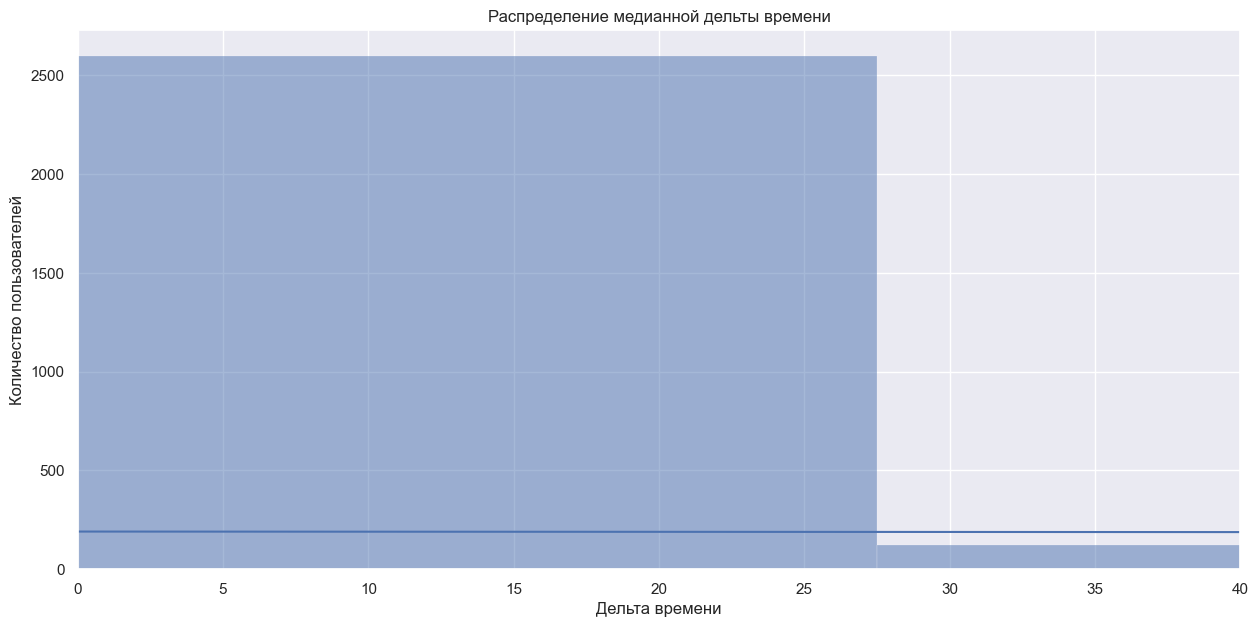

In [29]:
#определим таймаут
delta_df = df.sort_values(['user_id', 'event_time'])
delta_df['delta_event_time'] = delta_df.groupby('user_id')['event_time'].diff().dt.total_seconds() / 60
delta_df = delta_df.groupby('user_id')[['delta_event_time']].mean()
plt.figure(figsize=(15, 7))
sns.histplot(data=delta_df, x='delta_event_time', kde=True)
plt.title('Распределение медианной дельты времени')
plt.xlabel('Дельта времени')
plt.ylabel('Количество пользователей')
plt.xlim(0,40)
plt.show()

Из графика видно что за таймаут можно взять 27 минут

In [30]:
#определим сессии с помощью тайм-аута 27 минут
df = df.sort_values(['user_id', 'event_time'])
g = (df.groupby('user_id')['event_time'].diff() > pd.Timedelta('27Min')).cumsum()
df['session_id'] = df.groupby(['user_id', g], sort=False).ngroup() + 1

In [31]:
#добавим для каждой сессии время начало и время конца сесии
start = df.groupby('session_id')['event_time'].min()
end = df.groupby('session_id')['event_time'].max()
first = df.groupby('user_id')['event_time'].min()
df = df.merge(start, on='session_id', how='left')
df = df.merge(end, on='session_id', how='left')
df = df.rename(columns={'event_time_x': 'event_time', 'event_time_y': 'session_start', 'event_time': 'session_end'})
df = df.merge(first, on='user_id', how='left')
df = df.rename(columns={'event_time_x': 'event_time', 'event_time_y': 'first_session'})
df

user_id  source  \
0      0001b1d5-b74a-4cbf-aeb0-7df5947bf349   other   
1      0001b1d5-b74a-4cbf-aeb0-7df5947bf349   other   
2      0001b1d5-b74a-4cbf-aeb0-7df5947bf349   other   
3      0001b1d5-b74a-4cbf-aeb0-7df5947bf349   other   
4      0001b1d5-b74a-4cbf-aeb0-7df5947bf349   other   
...                                     ...     ...   
74192  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  google   
74193  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  google   
74194  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  google   
74195  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  google   
74196  fffb9e79-b927-4dbb-9b48-7fd09b23a62b  google   

                      event_time     event_name  event_date  event_day  \
0     2019-10-07 13:39:45.989359      tips_show  2019-10-07          1   
1     2019-10-07 13:40:31.052909      tips_show  2019-10-07          1   
2     2019-10-07 13:41:05.722489      tips_show  2019-10-07          1   
3     2019-10-07 13:43:20.735461      tips_show  2019-10-07          1   
4     2019-10-07 13:45:30.917502      tips_show  2019-10-07          1   
...                          ...            ...         ...        ...   
74192 2019-11-03 15:51:23.959572      tips_show  2019-11-03          7   
74193 2019-11-03 15:51:57.899997  show_contacts  2019-11-03          7   
74194 2019-11-03 16:07:40.932077      tips_show  2019-11-03          7   
74195 2019-11-03 16:08:18.202734      tips_show  2019-11-03          7   
74196 2019-11-03 16:08:25.388712      tips_show  2019-11-03          7   

       session_id              session_start                session_end  \
0               1 2019-10-07 13:39:45.989359 2019-10-07 13:49:41.716617   
1               1 2019-10-07 13:39:45.989359 2019-10-07 13:49:41.716617   
2               1 2019-10-07 13:39:45.989359 2019-10-07 13:49:41.716617   
3               1 2019-10-07 13:39:45.989359 2019-10-07 13:49:41.716617   
4               1 2019-10-07 13:39:45.989359 2019-10-07 13:49:41.716617   
...           ...                        ...                        ...   
74192       10514 2019-11-03 15:36:01.007440 2019-11-03 16:08:25.388712   
74193       10514 2019-11-03 15:36:01.007440 2019-11-03 16:08:25.388712   
74194       10514 2019-11-03 15:36:01.007440 2019-11-03 16:08:25.388712   
74195       10514 2019-11-03 15:36:01.007440 2019-11-03 16:08:25.388712   
74196       10514 2019-11-03 15:36:01.007440 2019-11-03 16:08:25.388712   

                   first_session  
0     2019-10-07 13:39:45.989359  
1     2019-10-07 13:39:45.989359  
2     2019-10-07 13:39:45.989359  
3     2019-10-07 13:39:45.989359  
4     2019-10-07 13:39:45.989359  
...                          ...  
74192 2019-10-12 00:57:21.241896  
74193 2019-10-12 00:57:21.241896  
74194 2019-10-12 00:57:21.241896  
74195 2019-10-12 00:57:21.241896  
74196 2019-10-12 00:57:21.241896  

[74197 rows x 10 columns]

In [32]:
#определим количество шагов для диаграммы Санкея
sorted_df = df.sort_values(by=['session_id', 'event_time']).copy()
sorted_df['step'] = sorted_df.groupby('session_id').cumcount() + 1
sorted_df['source'] = sorted_df['event_name']
sorted_df['target'] = sorted_df.groupby('session_id')['source'].shift(-1)
sorted_df = sorted_df.query('source != target').drop(['event_name', 'session_start', 'session_end',
                                                     'event_date', 'event_day'], axis=1).dropna()
sorted_df = sorted_df.groupby('session_id')[['event_time']].nunique()
sorted_df.describe(percentiles=[0.05, 1/4, 1/2, 3/4, 0.95, 0.99])

event_time
count     5111.00
mean         4.10
std          6.57
min          1.00
5%           1.00
25%          1.00
50%          2.00
75%          4.00
95%         14.00
99%         31.00
max        107.00

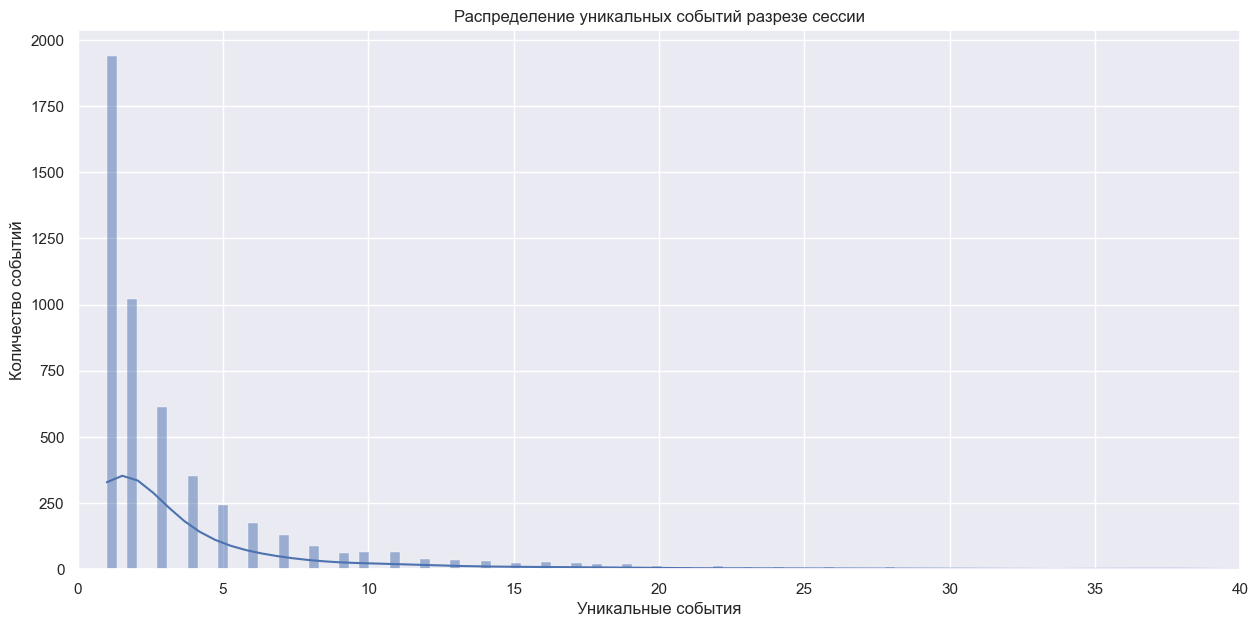

In [33]:
plt.figure(figsize=(15, 7))
sns.histplot(data=sorted_df, x='event_time', kde=True)
plt.title('Распределение уникальных событий разрезе сессии')
plt.xlabel('Уникальные события')
plt.ylabel('Количество событий')
plt.xlim(0,40)
plt.show()

Медианное значение количества уникальных событий на сессиию равно 4.10. Можно взять для построения диаграммы Санкея 5 шагов.

#### Анализ сценариев
Для анализа сценариев посмотрим CJM – пользовательский путь. Для этого построем диаграму Санкея

In [34]:
#подготовим данные для диаграмы
def add_features(df):
    
    """Функция генерации новых столбцов для исходной таблицы

    Args:
        df (pd.DataFrame): исходная таблица.
    Returns:
        pd.DataFrame: таблица с новыми признаками.
    """
    
    # сортируем по id и времени
    sorted_df = df.sort_values(by=['session_id', 'event_time']).copy()
    # добавляем шаги событий
    sorted_df['step'] = sorted_df.groupby('session_id').cumcount() + 1
    
    # добавляем узлы-источники и целевые узлы
    # узлы-источники - это сами события
    sorted_df['source'] = sorted_df['event_name']
    # добавляем целевые узлы
    sorted_df['target'] = sorted_df.groupby('session_id')['source'].shift(-1)
    
    # возврат таблицы без имени событий и лишних столбцов
    return sorted_df.query('source != target').drop(['event_name', 'session_start', 'session_end',
                                                     'event_date', 'user_id', 'event_day'], axis=1)
  
# преобразуем таблицу
table = add_features(df)
table

# удалим все пары source-target, шаг которых превышает 5
# и сохраним полученную таблицу в отдельную переменную
df_comp = table[table['step'] <= 5].copy().reset_index(drop=True)
df_comp

def get_source_index(df):
    
    """Функция генерации индексов source

    Args:
        df (pd.DataFrame): исходная таблица с признаками step, source, target.
    Returns:
        dict: словарь с индексами, именами и соответсвиями индексов именам source.
    """
    
    res_dict = {}
    
    count = 0
    # получаем индексы источников
    for no, step in enumerate(df['step'].unique().tolist()):
        # получаем уникальные наименования для шага
        res_dict[no+1] = {}
        res_dict[no+1]['sources'] = df[df['step'] == step]['source'].unique().tolist()
        res_dict[no+1]['sources_index'] = []
        for i in range(len(res_dict[no+1]['sources'])):
            res_dict[no+1]['sources_index'].append(count)
            count += 1
            
    # соединим списки
    for key in res_dict:
        res_dict[key]['sources_dict'] = {}
        for name, no in zip(res_dict[key]['sources'], res_dict[key]['sources_index']):
            res_dict[key]['sources_dict'][name] = no
    return res_dict
  

# создаем словарь
source_indexes = get_source_index(df_comp)

def colors_for_sources(mode):
    
    """Генерация цветов rgba

    Args:
        mode (str): сгенерировать случайные цвета, если 'random', а если 'custom' - 
                    использовать заранее подготовленные
    Returns:
        dict: словарь с цветами, соответствующими каждому индексу
    """
    # словарь, в который сложим цвета в соответствии с индексом
    colors_dict = {}
    
    if mode == 'random':
        # генерим случайные цвета
        for label in df_comp['source'].unique():
            r, g, b = np.random.randint(255, size=3)            
            colors_dict[label] = f'rgba({r}, {g}, {b}, 1)'
            
    elif mode == 'custom':
        # присваиваем ранее подготовленные цвета
        colors = requests.get('https://raw.githubusercontent.com/rusantsovsv/senkey_tutorial/main/json/colors_senkey.json').json()
        for no, label in enumerate(df_comp['source'].unique()):
            colors_dict[label] = colors['custom_colors'][no]
            
    return colors_dict
  
  
# генерю цвета из своего списка
colors_dict = colors_for_sources(mode='custom')

def percent_users(sources, targets, values):
    
    """
    Расчет уникальных id в процентах (для вывода в hover text каждого узла)
    
    Args:
        sources (list): список с индексами source.
        targets (list): список с индексами target.
        values (list): список с "объемами" потоков.
        
    Returns:
        list: список с "объемами" потоков в процентах
    """
    
    # объединим источники и метки и найдем пары
    zip_lists = list(zip(sources, targets, values))
    
    new_list = []
    
    # подготовим список словарь с общим объемом трафика в узлах
    unique_dict = {}
    
    # проходим по каждому узлу
    for source, target, value in zip_lists:
        if source not in unique_dict:
            # находим все источники и считаем общий трафик
            unique_dict[source] = 0
            for sr, tg, vl in zip_lists:
                if sr == source:
                    unique_dict[source] += vl
                    
    # считаем проценты
    for source, target, value in zip_lists:
        new_list.append(round(100 * value / unique_dict[source], 1))
    
    return new_list

def lists_for_plot(source_indexes=source_indexes, colors=colors_dict, frac=10):
    
    """
    Создаем необходимые для отрисовки диаграммы переменные списков и возвращаем
    их в виде словаря
    
    Args:
        source_indexes (dict): словарь с именами и индексами source.
        colors (dict): словарь с цветами source.
        frac (int): ограничение на минимальный "объем" между узлами.
        
    Returns:
        dict: словарь со списками, необходимыми для диаграммы.
    """
    
    sources = []
    targets = []
    values = []
    labels = []
    link_color = []
    link_text = []

    # проходим по каждому шагу
    for step in tqdm_notebook(sorted(df_comp['step'].unique()), desc='Шаг'):
        if step + 1 not in source_indexes:
            continue

        # получаем индекс источника
        temp_dict_source = source_indexes[step]['sources_dict']

        # получаем индексы цели
        temp_dict_target = source_indexes[step+1]['sources_dict']

        # проходим по каждой возможной паре, считаем количество таких пар
        for source, index_source in tqdm_notebook(temp_dict_source.items()):
            for target, index_target in temp_dict_target.items():
                # делаем срез данных и считаем количество id            
                temp_df = df_comp[(df_comp['step'] == step)&(df_comp['source'] == source)&(df_comp['target'] == target)]
                value = len(temp_df)
                # проверяем минимальный объем потока и добавляем нужные данные
                if value > frac:
                    sources.append(index_source)
                    targets.append(index_target)
                    values.append(value)
                    # делаем поток прозрачным для лучшего отображения
                    link_color.append(colors[source].replace(', 1)', ', 0.2)'))
                    
    labels = []
    colors_labels = []
    for key in source_indexes:
        for name in source_indexes[key]['sources']:
            labels.append(name)
            colors_labels.append(colors[name])
            
    # посчитаем проценты всех потоков
    perc_values = percent_users(sources, targets, values)
    
    # добавим значения процентов для howertext
    link_text = []
    for perc in perc_values:
        link_text.append(f"{perc}%")
    
    # возвратим словарь с вложенными списками
    return {'sources': sources, 
            'targets': targets, 
            'values': values, 
            'labels': labels, 
            'colors_labels': colors_labels, 
            'link_color': link_color, 
            'link_text': link_text}
  

# создаем словарь
data_for_plot = lists_for_plot()

def plot_senkey_diagram(data_dict=data_for_plot):    
    
    """
    Функция для генерации объекта диаграммы Сенкей 
    
    Args:
        data_dict (dict): словарь со списками данных для построения.
        
    Returns:
        plotly.graph_objs._figure.Figure: объект изображения.
    """
    
    fig = go.Figure(data=[go.Sankey(
        domain = dict(
          x =  [0,1],
          y =  [0,1]
        ),
        orientation = "h",
        valueformat = ".0f",
        node = dict(
          pad = 50,
          thickness = 15,
          line = dict(color = "black", width = 0.1),
          label = data_dict['labels'],
          color = data_dict['colors_labels']
        ),
        link = dict(
          source = data_dict['sources'],
          target = data_dict['targets'],
          value = data_dict['values'],
          label = data_dict['link_text'],
          color = data_dict['link_color']
      ))])
    fig.update_layout(title_text="Sankey Diagram", font_size=10, width=1500, height=1200)
    
    # возвращаем объект диаграммы
    return fig
  

# сохраняем диаграмму в переменную
senkey_diagram = plot_senkey_diagram()

Шаг:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [35]:
senkey_diagram.show()

Из Диаграмы Санкея можно выделить несколько сценариев.
1. map - tips_show - show_contacts
2. map - tips_show - advert_open- show_contacts
3. search - photos_show - show_contacts
4. tips_show - show_contacts


#### Построение воронок сценариев
1. map - tips_show - show_contacts
2. map - tips_show - advert_open - show_contacts
3. search - photos_show - show_contacts
4. tips_show - show_contacts

In [36]:
list_funnel=df.query('event_name == "map"')['user_id'].unique()
funnel=df.query('user_id in @list_funnel')
funnel=funnel.query('event_name == "map" or event_name== "tips_show" or event_name== "show_contacts"')
target_funnel=funnel.groupby('event_name')[['user_id']].nunique().sort_values('user_id',ascending=False)
fig = go.Figure()
fig.add_trace(go.Funnel(x=target_funnel['user_id'],y=target_funnel.index,textinfo = "value+percent initial+percent previous"))
fig.update_layout(title='Воронка по сценарию')
fig.show()

In [37]:
list_funnel=df.query('event_name == "map"')['user_id'].unique()
funnel=df.query('user_id in @list_funnel')
funnel=funnel.query('event_name == "map" or event_name== "tips_show" or event_name== "advert_open" or event_name== "show_contacts"')
target_funnel=funnel.groupby('event_name')[['user_id']].nunique().sort_values('user_id',ascending=False)
fig = go.Figure()
fig.add_trace(go.Funnel(x=target_funnel['user_id'],y=target_funnel.index,textinfo = "value+percent initial+percent previous"))
fig.update_layout(title='Воронка по сценарию')
fig.show()

In [38]:
list_funnel=df.query('event_name == "search"')['user_id'].unique()
funnel=df.query('user_id in @list_funnel')
funnel=funnel.query('event_name == "search" or event_name== "photos_show" or event_name== "show_contacts"')
target_funnel=funnel.groupby('event_name')[['user_id']].nunique().sort_values('user_id',ascending=False)
fig = go.Figure()
fig.add_trace(go.Funnel(x=target_funnel['user_id'],y=target_funnel.index,textinfo = "value+percent initial+percent previous"))
fig.update_layout(title='Воронка по сценарию')
fig.show()

In [39]:
list_funnel=df.query('event_name == "tips_show"')['user_id'].unique()
funnel=df.query('user_id in @list_funnel')
funnel=funnel.query('event_name == "tips_show" or event_name== "show_contacts"')
target_funnel=funnel.groupby('event_name')[['user_id']].nunique().sort_values('user_id',ascending=False)
fig = go.Figure()
fig.add_trace(go.Funnel(x=target_funnel['user_id'],y=target_funnel.index,textinfo = "value+percent initial+percent previous"))
fig.update_layout(title='Воронка по сценарию')
fig.show()

Наиболее выделяются сценарии начинающиеся с события map. Они имеею высокую конвертацию в второе событие tips_show. 

### Анализ удержания пользователя

In [40]:
#подготовим данные для расчета Retention Rate
retention = df.drop(['source', 'event_name', 'event_day', 'session_end', 'event_date', 'event_time'], axis=1)
retention = retention.drop_duplicates(subset=['session_id'], keep='first').reset_index(drop=True)
retention['first_session_day'] = retention.first_session.dt.date
retention

user_id  session_id  \
0      0001b1d5-b74a-4cbf-aeb0-7df5947bf349           1   
1      0001b1d5-b74a-4cbf-aeb0-7df5947bf349           2   
2      0001b1d5-b74a-4cbf-aeb0-7df5947bf349           3   
3      0001b1d5-b74a-4cbf-aeb0-7df5947bf349           4   
4      00157779-810c-4498-9e05-a1e9e3cedf93           5   
...                                     ...         ...   
10509  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10510   
10510  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10511   
10511  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10512   
10512  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10513   
10513  fffb9e79-b927-4dbb-9b48-7fd09b23a62b       10514   

                   session_start              first_session first_session_day  
0     2019-10-07 13:39:45.989359 2019-10-07 13:39:45.989359        2019-10-07  
1     2019-10-09 18:33:55.577963 2019-10-07 13:39:45.989359        2019-10-07  
2     2019-10-21 19:52:30.778932 2019-10-07 13:39:45.989359        2019-10-07  
3     2019-10-22 11:18:14.635436 2019-10-07 13:39:45.989359        2019-10-07  
4     2019-10-19 21:34:33.849769 2019-10-19 21:34:33.849769        2019-10-19  
...                          ...                        ...               ...  
10509 2019-11-02 01:16:48.947231 2019-10-12 00:57:21.241896        2019-10-12  
10510 2019-11-02 18:01:27.094834 2019-10-12 00:57:21.241896        2019-10-12  
10511 2019-11-02 19:25:53.794029 2019-10-12 00:57:21.241896        2019-10-12  
10512 2019-11-03 14:32:55.956301 2019-10-12 00:57:21.241896        2019-10-12  
10513 2019-11-03 15:36:01.007440 2019-10-12 00:57:21.241896        2019-10-12  

[10514 rows x 5 columns]

In [41]:
#функция для расчета Retention Rate
def get_retention(retention, observation_date, horizon_days, ignore_horizon=False):
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = retention.query('first_session_day <= @last_suitable_acquisition_date')
    # собираем «сырые» данные для расчёта удержания
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_session']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=['first_session_day'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('first_session_day')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='first_session_day', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

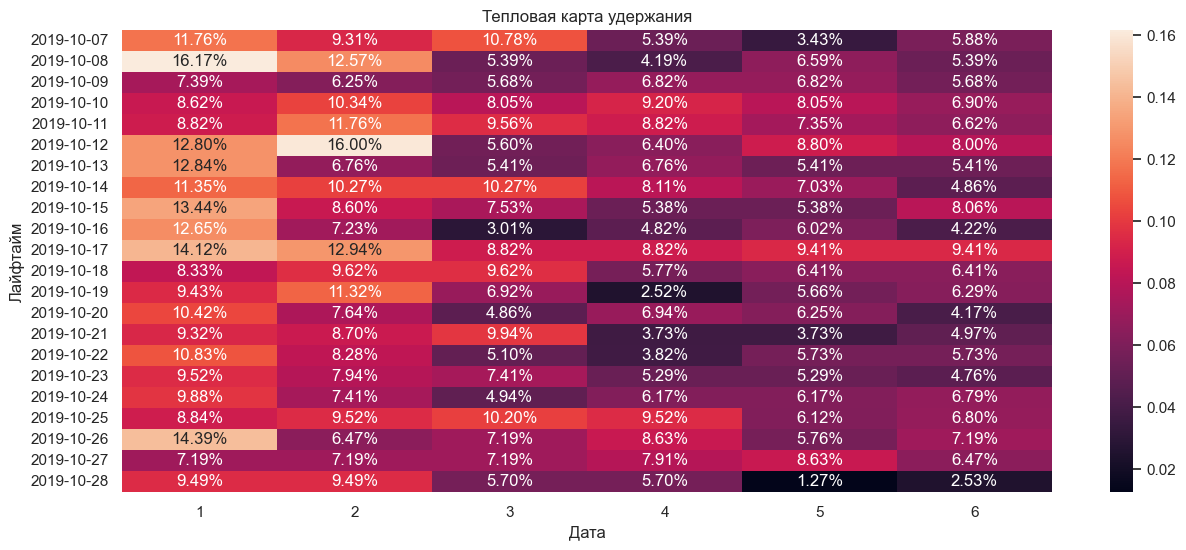

In [42]:
#строим хитмэп без нулевого лайфтайма
retention_raw, retention = get_retention(retention, datetime(2019, 10, 28).date(), 7, ignore_horizon=True)

plt.figure(figsize=(15, 6))  # задаём размер графика
sns.heatmap(
    retention.drop(columns=['cohort_size', 0]),  # удаляем лишние столбцы
    annot=True,  # включаем подписи
    fmt='.2%',  # переводим значения в проценты
)
plt.title('Тепловая карта удержания')  # название графика
plt.xlabel('Дата')
plt.ylabel('Лайфтайм')
plt.show()

9 октября было наибольшее удержание на второй день 16,17%. Так же хорошо себя показали 17 октебря и 26 октебря. Они расположены на примерно равном растоянии по времени друг от друга. Что может означать цикличность причины. На 7 день удержание колеблется в районе 5-7% с наибольшим удержанием 17 октября.

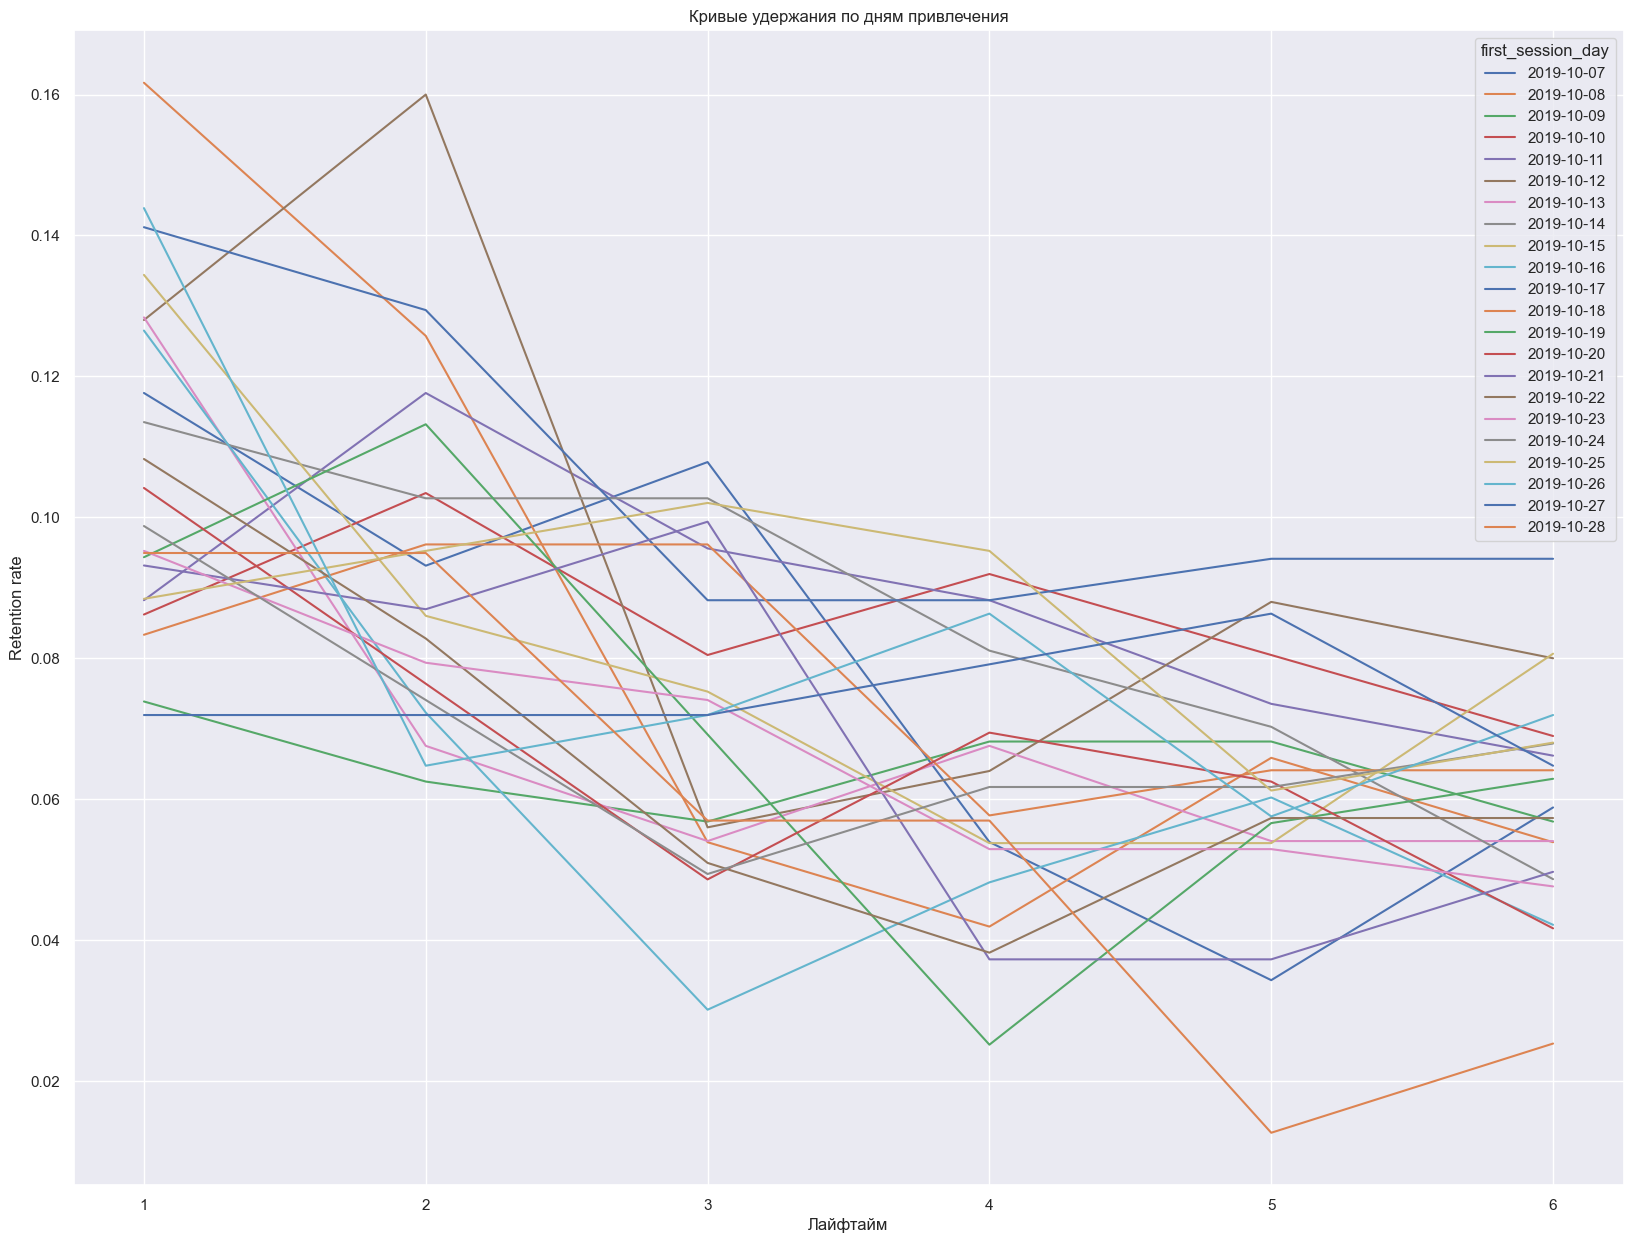

In [43]:
# строим кривые удержания
report = retention.drop(columns = ['cohort_size', 0])
report.T.plot(
    grid=True,  # добавляем сетку
    xticks=list(report.columns.values),  # отметки на оси X — названия колонок
    figsize=(20, 15),  # размер графика
)
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Кривые удержания по дням привлечения')  # название графика
plt.xlabel('Лайфтайм')
plt.ylabel('Retention rate')
plt.show()

В первые три дня видны сильные перепады кривых удержания. К концу 7 дня они в целом стабилизируятся с некоторым ростом.

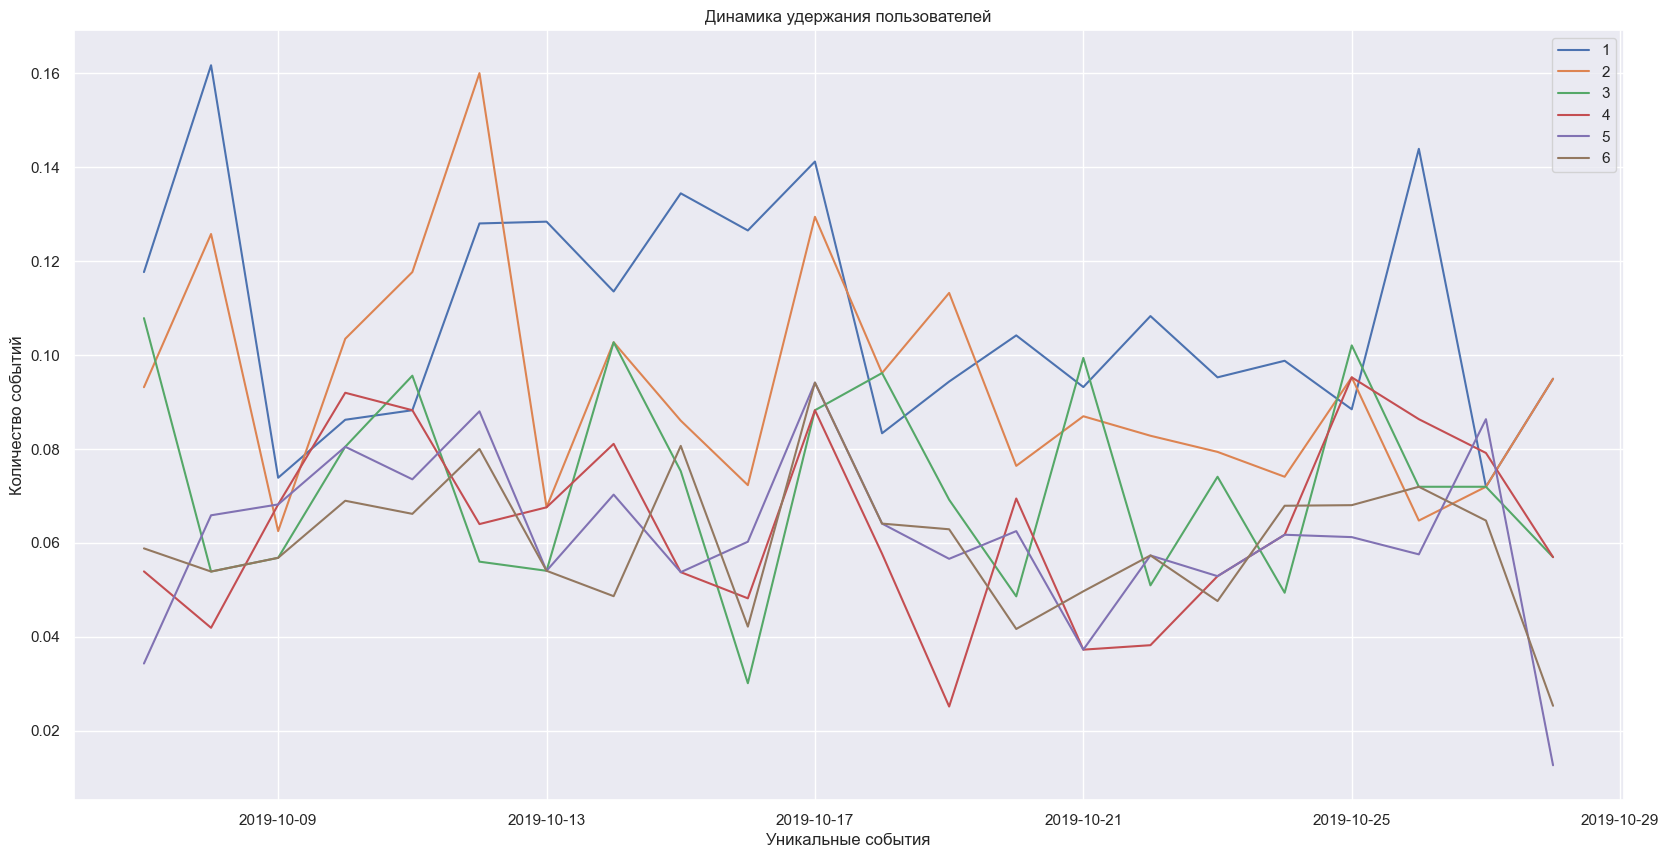

In [44]:
#строим графики изменений
report = retention.drop(columns=['cohort_size', 0])
report.plot(grid=True, figsize=(20, 10))
plt.xlabel('Дата привлечения')
plt.title('Динамика удержания пользователей')
plt.xlabel('Уникальные события')
plt.ylabel('Количество событий')
plt.show()

В целом динамика удержания в целом сохраняется на протяжении всего горизонта анализа

### Выводы
1. Среди событий которые совершают пользователи совершившие целевое действие лидирует tips_show с 12768 событиями, отстающее от него photos_show c 3828 событиями и search с 2084. Наименее популярным событием оказался tips_click с 333 событиями.
2. Наилучшую конверсию в целевое действие имеют favorites_add с 38.75%, tips_click с 31.06% и photos_show с 30.96%
3. Выделяются следующие сценарии использования приложения: 
    1. map - tips_show - show_contacts
    2. map - tips_show - advert_open - show_contacts
    3. search - photos_show - show_contacts
    4. tips_show - show_contacts
4. Наиболее выделяются сценарии начинающиеся с события map. Они имеею высокую конвертацию в второе событие tips_show.
5. 9 октября было наибольшее удержание на второй день 16,17%. Так же хорошо себя показали 17 октебря и 26 октебря. Они расположены на примерно равном растоянии по времени друг от друга. Что может означать цикличность причины. На 7 день удержание колеблется в районе 5-7% с наибольшим удержанием 17 октября.

## Проверка статестических гипотез
Сформулируем гипотезы.
1. Одни пользователи совершают действие tips_show и tips_click, другие - только tips_show. 
    * H0 Статистически значимых различий конверсии в просмотры контактов между группами нет.
    * H1 Статистически значимых различий конверсии в просмотры контактов между группами есть.
2. Одни пользователи совершают действие favorites_add, а другие нет
    * H0 Статистически значимых различий конверсии в просмотры контактов между группами нет.
    * H1 Статистически значимых различий конверсии в просмотры контактов между группами есть.
3. Пользователи установившие приложения из двух наиболее популярных источников
    * H0 Статистически значимых различий конверсии в просмотры контактов между группами нет.
    * H1 Статистически значимых различий конверсии в просмотры контактов между группами есть.

In [45]:
# напишем функцию для проверки гипотез
shidak_count = 1
def test_stat(group_1, group_2, alpha_value=.05, shidak = None):
    
    '''
    group_1 и group_2 принимают номера групп для которых производятся сравнения;
    alpha_value - значение альфы, по умолчанию 0.05.
    '''
    #проверка пересечения групп
    coincide=list(set(group_1['user_id']) & set(group_2['user_id']))
    if len(coincide) > 0:
        print('В группах есть пересечения')
        return {'coincide': len(coincide)}
    
    # подготовим переменные
    success_1 = group_1.query('event_name == "show_contacts"')['user_id'].nunique()
    success_2 = group_2.query('event_name == "show_contacts"')['user_id'].nunique()
    trials_1 = group_1['user_id'].nunique()
    trials_2 = group_2['user_id'].nunique()
    
    # учтем возможность поправки Шидака в коде функции
    global shidak_count
    if shidak is not None:
        shidak_alpha = 1 - (1 - alpha_value)**(1/shidak_count)
        alpha = shidak_alpha
        shidak_count = shidak_count + 1
    else:
        alpha = alpha_value
    
    # сформулируем гипотезы
    print('-' * 120)
    print(f'''Сформулируем гипотезы для сравнения:
    H0: Статистически значимых различий конверсии в просмотры контактов между группами нет.
    H1 Статистически значимых различий конверсии в просмотры контактов между группами есть.''')
    print('-' * 120)
    print()
    
    print(success_1, success_2, trials_1, trials_2) #КОД РЕВЬЮЕРА
    
    
    # провередм расчеты
    # пропорция успехов в первой группе:
    p1 = success_1/trials_1
    # пропорция успехов во второй группе:
    p2 = success_2/trials_2
    # пропорция успехов в комбинированном датасете:
    p_combined = (success_1 + success_2) / (trials_1 + trials_2)
    # разница пропорций в датасетах
    dif = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = dif / (p_combined * (1 - p_combined) * (1/trials_1 + 1/trials_2)) ** 0.5
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    # выведем статистические показатели расчетов
    print('Статистические показатели')
    print(f'р-value {p_value}:')
    print(f'Для первой группы {success_1} из {trials_1} это {p1:.2%}')
    print(f'Для второй группы {success_2} из {trials_2} это {p2:.2%}')
    print('-' * 120)
    print()
    
    # выведем итоги сравнения гипотез
    print('Вывод')
    if p_value < alpha:
        print((f'Отвергаем нулевую гипотезу: разница между группами статистически значима'))
    else:
        print(
            f'Не получилось отвергнуть нулевую гипотезу для сравнения групп, вывод о различии сделать нельзя.'
        )   
    print('=' * 120)
    print()
    
    #return {'pvalue': p_value}

### Проверка первой гипотезы 
Одни пользователи совершают действие `tips_show` и `tips_click`, другие - только `tips_show`. Проверить гипотезу: конверсия в просмотры контактов различается у этих двух групп.

In [46]:
list_1 = df.query('event_name == "tips_click"')['user_id']
group_1 = df.query('user_id in @list_1')
group_2 = df.query('user_id not in @list_1')
list_1 = df.query('event_name == "tips_show"')['user_id']
group_1 = group_1.query('user_id in @list_1')
group_2 = group_2.query('user_id in @list_1')
test_stat(group_1, group_2, shidak = 3)

------------------------------------------------------------------------------------------------------------------------
Сформулируем гипотезы для сравнения:
    H0: Статистически значимых различий конверсии в просмотры контактов между группами нет.
    H1 Статистически значимых различий конверсии в просмотры контактов между группами есть.
------------------------------------------------------------------------------------------------------------------------

91 425 297 2504
Статистические показатели
р-value 9.218316554537864e-09:
Для первой группы 91 из 297 это 30.64%
Для второй группы 425 из 2504 это 16.97%
------------------------------------------------------------------------------------------------------------------------

Вывод
Отвергаем нулевую гипотезу: разница между группами статистически значима



### Проверка второй гипотезы
Одни пользователи совершают действие `favorites_add`, а другие нет. Проверить гипотезу: конверсия в просмотры контактов различается у этих двух групп.

In [47]:
list_1 = df.query('event_name == "favorites_add"')['user_id']
group_1 = df.query('user_id in @list_1')
group_2 = df.query('user_id not in @list_1')
test_stat(group_1, group_2, shidak = 3)

------------------------------------------------------------------------------------------------------------------------
Сформулируем гипотезы для сравнения:
    H0: Статистически значимых различий конверсии в просмотры контактов между группами нет.
    H1 Статистически значимых различий конверсии в просмотры контактов между группами есть.
------------------------------------------------------------------------------------------------------------------------

136 845 351 3942
Статистические показатели
р-value 1.3455903058456897e-13:
Для первой группы 136 из 351 это 38.75%
Для второй группы 845 из 3942 это 21.44%
------------------------------------------------------------------------------------------------------------------------

Вывод
Отвергаем нулевую гипотезу: разница между группами статистически значима



### Проверка третьей гипотезы
Пользователи установившие приложения из двух наиболее популярных источников. Проверьте гипотезу: конверсия в просмотры контактов различается у этих двух групп.

In [48]:
list_1 = df.query('source == "yandex"')['user_id']
list_2 = df.query('source == "google"')['user_id']
group_1 = df.query('user_id in @list_1')
group_2 = df.query('user_id in @list_2')
test_stat(group_1, group_2, shidak = 3)

------------------------------------------------------------------------------------------------------------------------
Сформулируем гипотезы для сравнения:
    H0: Статистически значимых различий конверсии в просмотры контактов между группами нет.
    H1 Статистически значимых различий конверсии в просмотры контактов между группами есть.
------------------------------------------------------------------------------------------------------------------------

478 275 1934 1129
Статистические показатели
р-value 0.8244316027993777:
Для первой группы 478 из 1934 это 24.72%
Для второй группы 275 из 1129 это 24.36%
------------------------------------------------------------------------------------------------------------------------

Вывод
Не получилось отвергнуть нулевую гипотезу для сравнения групп, вывод о различии сделать нельзя.



### Выводы
1. Одни пользователи совершают действие tips_show и tips_click, другие - только tips_show. Нулевая гепотеза была отвергнута, разница между группами статистически значима.

2. Одни пользователи совершают действие favorites_add, а другие нет. Нулевая гепотеза была отвергнута, разница между группами статистически значима.

3. Пользователи установившие приложения из двух наиболее популярных источников. Не получилось отвергнуть нулевую гипотезу для сравнения групп, вывод о различии сделать нельзя.


##  Выводы


### Исследовательский анализ данных
1. Всего в логе 74197 событий и 4293 пользователей. Наиболее частым событием является tips_show, photos_show, advert_open
2. В среднем, на каждого пользователя приходится 17 событий. Медианное количество при этом составляет 9, и всего у одного процента пользователей количество событий переваливает за 132. Большое различие между средним и медианным показывает наличие выбросов.
3. Наиболее популярные источники yandex и google.
4. Максимальная дата события 2019-11-03 23:58:12, минимальная дата события 2019-10-07 00:00:00, сырые данные предоставлены за период 27 days 23:58:12. За весь период данных не видно резких скачков и падений количества событий. Имеет смысл в исследовании рассматривать весь предоставленный период. В понедельник наидольшая активность, затем она постепенно падает к субботе и возрастает снова в воскресенье.
5. По количеству событий преобладает search_1. Все варианты поиска равно распределены и по источникам и по времени. Без дополнительной расшифровки значения каждого поиска сложно выделять какие-то закономерности.
6. Всего 22.85% всех пользователей совершили целевое действие

### Основная цель исследования
1. Среди событий которые совершают пользователи совершившие целевое действие лидирует tips_show с 12768 событиями, отстающее от него photos_show c 3828 событиями и search с 2084. Наименее популярным событием оказался tips_click с 333 событиями.
2. Наилучшую конверсию в целевое действие имеют favorites_add с 38.75%, tips_click с 31.06% и photos_show с 30.96%
3. Выделяются следующие сценарии использования приложения: 
    1. map - tips_show - show_contacts
    2. map - tips_show - advert_open - show_contacts
    3. search - photos_show - show_contacts
    4. tips_show - show_contacts
4. Наиболее выделяются сценарии начинающиеся с события map. Они имеею высокую конвертацию в второе событие tips_show.
5. 9 октября было наибольшее удержание на второй день 16,17%. Так же хорошо себя показали 17 октебря и 26 октебря. Они расположены на примерно равном растоянии по времени друг от друга. Что может означать цикличность причины. На 7 день удержание колеблется в районе 5-7% с наибольшим удержанием 17 октября.

### Проверка статистических гипотез
1. Одни пользователи совершают действие tips_show и tips_click, другие - только tips_show. Нулевая гепотеза была отвергнута, разница между группами статистически значима.

2. Одни пользователи совершают действие favorites_add, а другие нет. Нулевая гепотеза была отвергнута, разница между группами статистически значима.

3. Пользователи установившие приложения из двух наиболее популярных источников. Не получилось отвергнуть нулевую гипотезу для сравнения групп, вывод о различии сделать нельзя.

## Рекомендации
1. Количество пользователей из google почти в два раза меньше чем из yandex. При этом они имеют одинаковый показатель конверсии в целевое действие. Это позволит увеличить приток пользователей из источника google дешевле чем из яндекса не теряя в конверсии.
2. Понедельник и воскресенье самые активные дни. Стоит повысить рекомендации в эти дни.
3. Событие map часто используемое в начале сценария использования приложения. Улучшения интерфейса данной функции может приветси к улучшению конверсии.
4. tips_click наименее популярное событие среди ползователей которые совершили целевое действие. Его показатели намного ниже чем tips_show. Стоит разобраться почему люди не кликают на рекомендованные объявления.
5. В сценарияю map - tips_show после tips_show идет резкое падени уровня кореляции по сравнению с прошлым шагом. Возможно с рекомендациями что-то не так.